In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Strategy Backtester

## Data

From poloniex:

https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1521746902&end=9999999999&period=14400

In [2]:
import calendar
import requests
import pandas as pd 
from datetime import datetime, timedelta

In [3]:
def unix_epoch_to_timestamp(epoch):
    return datetime.fromtimestamp(epoch).strftime('%Y-%m-%d %H:%M:%S')

In [4]:
def timestamp_to_unix_epoch(ts):
    return calendar.timegm(ts.timetuple())

In [5]:
class PoloniexDataFrame():
    def __init__(self, pair, timeframe, start, end):
        start = timestamp_to_unix_epoch(start)
        end = timestamp_to_unix_epoch(end)
        url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'.format(pair, start, end, timeframe) 
        print(url)
        json = requests.get(url)
        data = json.json()
        date, o, h, l, c = zip(*[(unix_epoch_to_timestamp(x['date']), x['close'], x['high'], x['low'], x['close']) for x in data])
        d = {'date': date, 'open': o, 'high': h, 'low': l, 'close': c}
        self.data = pd.DataFrame(data=d)

In [6]:
import dateutil.parser

In [7]:
dateutil.parser.parse('2018-04-04 17:30:00')

datetime.datetime(2018, 4, 4, 17, 30)

In [8]:
start = datetime.utcnow() - timedelta(days=7*2)
end = datetime.utcnow()
#start = dateutil.parser.parse('2018-04-04 17:30:00')
#end = dateutil.parser.parse('2018-04-12 00:30:00')
                                    # Min * 60 Sec
#plnx = PoloniexDataFrame('USDT_BTC', 5*60, start, end) #  0.45% 
#plnx = PoloniexDataFrame('USDT_BTC', 15*60, start, end) #  -13.02%
plnx = PoloniexDataFrame('USDT_BTC', 30*60, start, end) # 23.65%
#plnx = PoloniexDataFrame('USDT_BTC', 120*60, start, end) # 3.84%
#lnx = PoloniexDataFrame('USDT_BTC', 240*60, start, end) # 10.948%

https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1523924361&end=1525133961&period=1800


'2018-04-04 17:30:00'
'2018-04-12 00:30:00'

## Indicators

Indicators to add:

 * EMA
 * MACD
 * BBands
 * RSI

### Daily returns

In [9]:
def daily_returns(df): df['daily_returns'] = df['close'] - df['close'].shift(1)

### Stdev

In [10]:
def std(df, n): df['std{}'.format(n)] = df['close'].rolling(window=n).std()
std_list = [7]

### Simple Moving Average (SMA)

In [11]:
def sma(df, n): df['sma{}'.format(n)] = df['close'].rolling(window=n).mean()
sma_list = range(1, 30)

### Adding all the data & indicators

In [12]:
daily_returns(plnx.data)
for n in std_list: std(plnx.data, n)
for n in sma_list: sma(plnx.data, n)

In [13]:
class Indicators():
    std_list = [7]
    sma_list = range(5, 30)
    
    def daily_returns(self, df): df['daily_returns'] = df['close'] - df['close'].shift(1)
    def std(self, df, n): df['std{}'.format(n)] = df['close'].rolling(window=n).std()
    def sma(self, df, n): df['sma{}'.format(n)] = df['close'].rolling(window=n).mean()
        
    def apply(self, df):
        self.daily_returns(df)
        for n in self.std_list: self.std(df, n) 
        for n in self.sma_list: self.sma(df, n)

## Plot

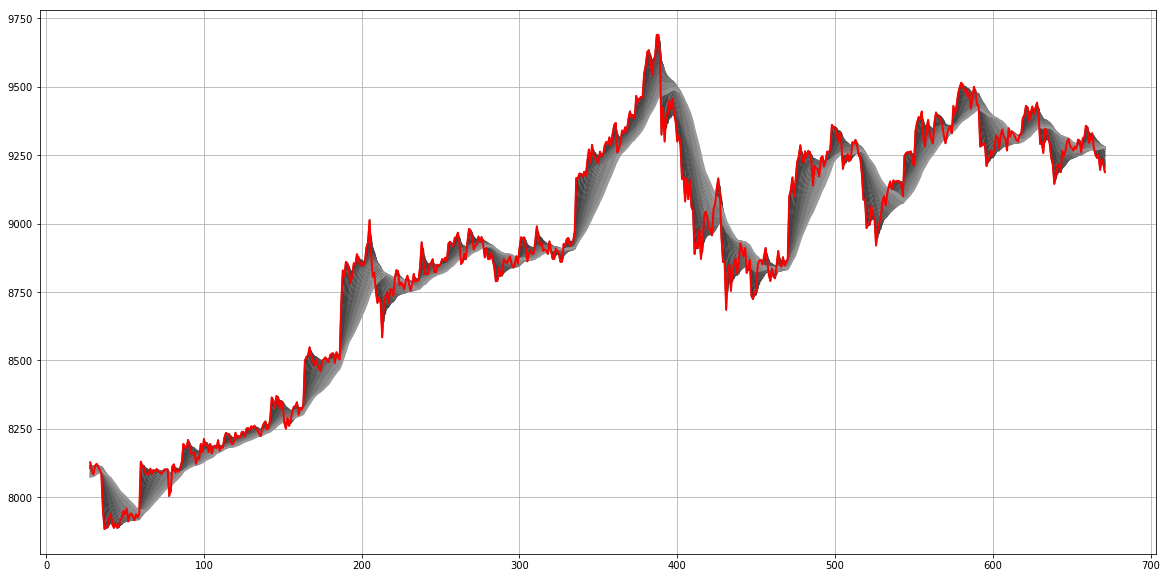

In [14]:
head=max(sma_list)-1
plt.figure(figsize=(20,10))

for i in sma_list: plot(plnx.data[head:]['sma{}'.format(i)], color='#{}'.format(str(3+round(6*i/len(sma_list)))*6))

plot(plnx.data[head:]['close'], c='r', lw=2)
plt.grid()

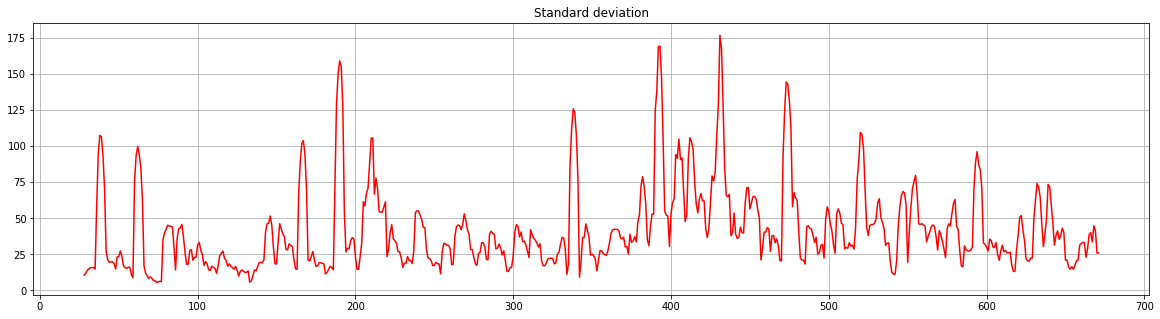

In [15]:
plt.figure(figsize=(20,5))
plot(plnx.data[head:]['std7'], c='r')
plt.title('Standard deviation')
plt.grid()

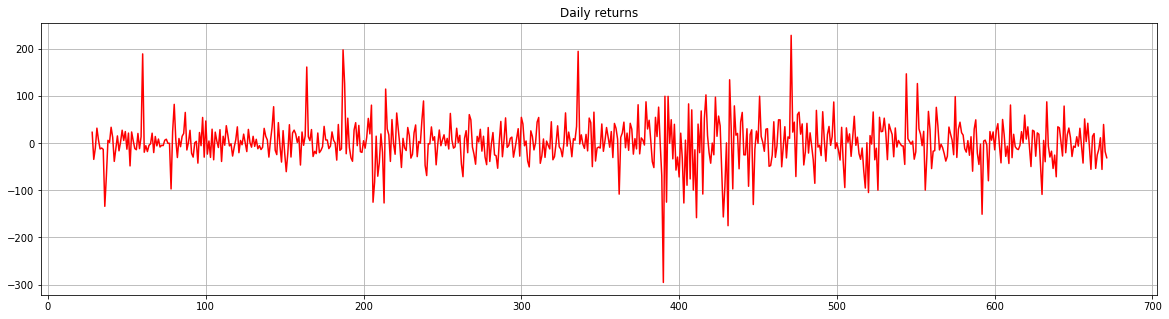

In [16]:
plt.figure(figsize=(20,5))
plot(plnx.data[head:]['daily_returns'], c='r')
plt.title('Daily returns')
plt.grid()

## Signals

### Moving average crossover

In [17]:
def signals_ma_crossover(df, skip_head, sma_list):
    sma1 = 'sma{}'.format(sma_list[0])
    sma2 = 'sma{}'.format(sma_list[1])
    df['signal_sma_crossover'] = 0
    for i in range(skip_head, len(df)):
        previous = df.iloc[i-1]
        current = df.iloc[i]
        sma_prev = previous[sma1] - previous[sma2]
        sma_current = current[sma1] - current[sma2]
        if sma_prev > 0 and sma_current < 0: df.loc[i,'signal_sma_crossover'] = -1
        if sma_prev < 0 and sma_current > 0: df.loc[i,'signal_sma_crossover'] = 1

In [18]:
signals = signals_ma_crossover(plnx.data, 23, [7, 23])

## Trading simulation

In [19]:
class RiskManagement():
    def __init__(self, use_stop_loss, stop_loss_percentage):
        self.use_stop_loss = use_stop_loss
        self.stop_loss_percentage = stop_loss_percentage

In [20]:
from matplotlib import gridspec

In [41]:
class TradeSim():
    def __init__(self, df, risk):
        self.df = df
        self.risk = risk
        
    def run(self):
        state = 'neutral'
        entry = None
        entry_timestamp = None
        tlist = []
        for index in range(len(self.df)):
            current = self.df.iloc[index]
            sma_crossover = self.df.loc[index]
            if state != 'neutral':
                pl_low = ((current['low'] / entry if state == 'long' else entry / current['low']) - 1) * 100
                if self.risk.use_stop_loss and pl_low < -self.risk.stop_loss_percentage:
                    tlist.append([entry, current['close'], state, entry_timestamp, current['date'], 'stopped_out'])
                    state = 'neutral'
            if current['signal_sma_crossover'] == 1:
                if state == 'short':
                    tlist.append([entry, current['close'], 'short', entry_timestamp, current['date'], 'closed'])
                    state = 'neutral'
                entry = current['close']
                entry_timestamp = current['date']
                state = 'long'
            if current['signal_sma_crossover'] == -1:
                if state == 'long':
                    tlist.append([entry, current['close'], 'long', entry_timestamp, current['date'], 'closed'])
                    state = 'neutral'
                entry = current['close']
                entry_timestamp = current['date']
                state = 'short'
        self.trades = pd.DataFrame(tlist, columns=['entry', 'exit', 'direction', 'entry_timestamp', 'exit_timestamp', 'close_type'])
        self.trades['gains'] = self.trades.apply(self.gains, axis=1)
        self.trades['gains'] = self.trades.apply(self.stopped_out, axis=1)
        self.trades['gains_cumsum'] = self.trades['gains'].cumsum()
        self.add_gains_to_dataframe()
        
    def gains(self, row):
        if row['direction'] == 'long':  return (row['exit'] / row['entry'] - 1) * 100
        if row['direction'] == 'short': return (row['entry'] / row['exit'] - 1) * 100
        
    def add_gains_to_dataframe(self):
        self.df['gains'] = 0
        for index in range(len(self.trades)):
            t = self.trades.iloc[index]
            self.df.loc[self.df['date'] == t['exit_timestamp'], 'gains'] = t['gains']
        self.df['gains_cumsum'] = self.df['gains'].cumsum()
            
    def stopped_out(self, row):
        return -self.risk.stop_loss_percentage if row['close_type'] == 'stopped_out' else row['gains']
    
    def plot_chart(self):
        plt.figure(figsize=(20,5))
        plot(self.trades['close'])
    
    def plot_gains(self):
        plt.figure(figsize=(20,5))
        plt.title('Gains (cumulative)')
        plot(self.trades['gains_cumsum'])
        plt.grid()
        
    def result_statistics(self):
        winners = len(self.trades.loc[self.trades['gains'] > 0])
        losers = len(self.trades.loc[self.trades['gains'] < 0])
        stopped_out = len(self.trades.loc[self.trades['close_type'] == 'stopped_out'])
        print('Period start: {}'.format(self.df.iloc[0]['date']))
        print('Period end: {}'.format(self.df.iloc[len(self.df)-1]['date']))
        print('Total trades: {}'.format(winners+losers))
        print('Winners: {}'.format(winners))
        print('Losers: {}'.format(losers))
        print('Win Ratio: {:.3f}%'.format(winners / (winners+losers) * 100))
        print('Stopped out: {}'.format(stopped_out))
        print('P/L: {:.2f}%'.format(self.df.iloc[len(self.df)-1]['gains_cumsum']))
        
    def plot_gains_timescale(self):
        gs = gridspec.GridSpec(3, 1, height_ratios=[3,1,1])
        f = plt.figure(figsize=(20,15)) #plt.subplots(gs, sharex=True, figsize=(20,10))
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        ax3 = plt.subplot(gs[2])
        ax1.plot(trade_sim.df['close'], c='black', lw=1.)
        ax1.plot(trade_sim.df['high'], c='black', ls='dashed', lw=1., alpha=0.5)
        ax1.plot(trade_sim.df['low'], c='black', ls='dashed', lw=1., alpha=0.5)
        ax1.fill_between(list(trade_sim.df.index), trade_sim.df['low'], trade_sim.df['high'], alpha=0.25)
        ax1.plot(trade_sim.df['sma8'], c='lime', lw=2.)
        ax1.plot(trade_sim.df['sma23'], c='red', lw=2.)
        ax1.legend(['Close', 'High', 'Low', 'SMA1', 'SMA2'])
        ax1.grid()
        ax2.axhline(y=0, c='black', ls='dashed')
        ax2.step(list(trade_sim.df.index), trade_sim.df['signal_sma_crossover'], c='blue', lw=1.)
        ax2.legend(['0', 'Signal'])
        ax2.grid()
        ax3.axhline(y=0, c='black', ls='dashed')
        ax3.step(list(trade_sim.df.index), trade_sim.df['gains_cumsum'], c='blue', lw=2.)
        ax3.grid()
        ax3.legend(['0', 'Gains %'])
        f.subplots_adjust(hspace=0)

Period start: 2018-04-17 02:30:00
Period end: 2018-05-01 02:00:00
Total trades: 26
Winners: 10
Losers: 16
Win Ratio: 38.462%
Stopped out: 9
P/L: 9.54%


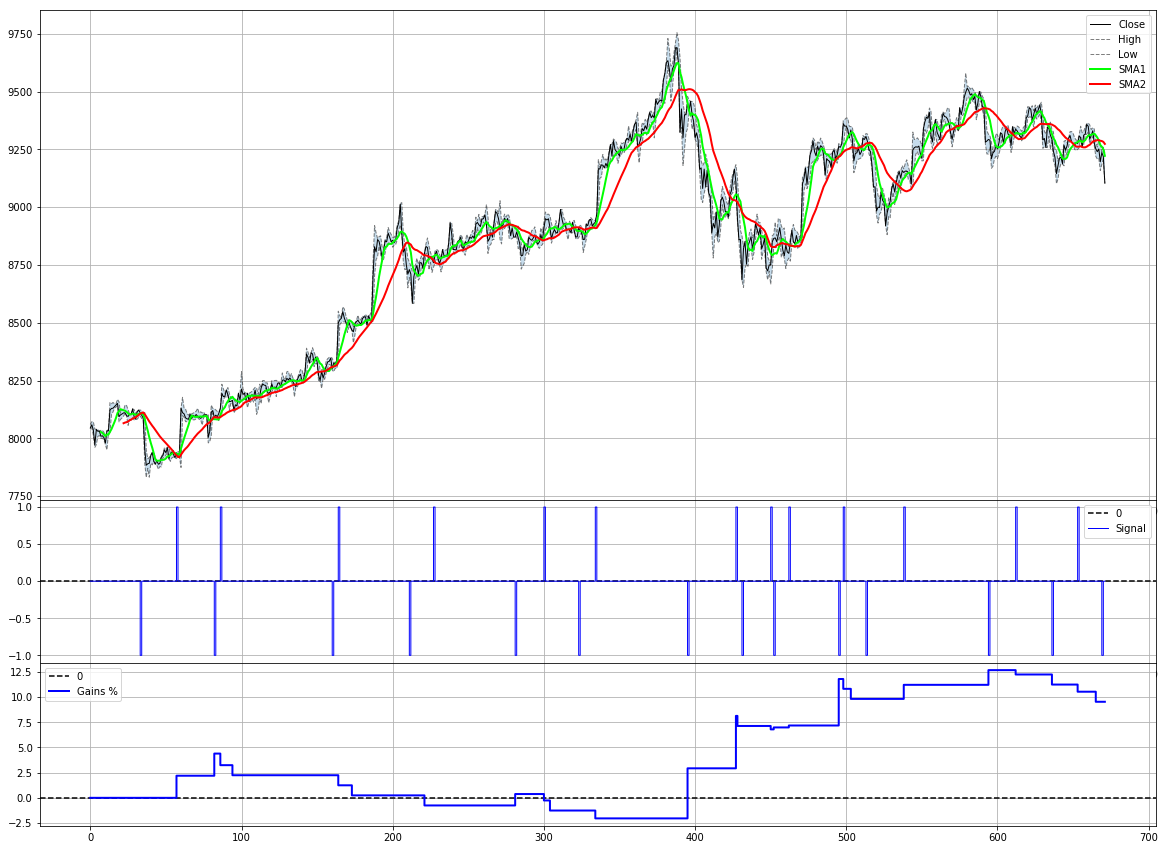

In [42]:
risk_mgmnt = RiskManagement(True, 1)
trade_sim = TradeSim(plnx.data, risk_mgmnt)
trade_sim.run()
trade_sim.result_statistics()
trade_sim.plot_gains_timescale()

In [36]:
trade_sim.trades

,entry,exit,direction,entry_timestamp,exit_timestamp,close_type,gains,gains_cumsum
0,8100.000000,7926.000000,short,2018-04-17 19:30:00,2018-04-18 07:30:00,closed,2.195307,2.195307
1,7926.000000,8100.318522,long,2018-04-18 07:30:00,2018-04-18 20:00:00,closed,2.199325,4.394632
2,8100.318522,8194.623789,short,2018-04-18 20:00:00,2018-04-18 22:00:00,closed,-1.150819,3.243813
3,8194.623789,8122.068420,long,2018-04-18 22:00:00,2018-04-19 02:00:00,stopped_out,-1.000000,2.243813
4,8325.032183,8513.000000,short,2018-04-20 11:00:00,2018-04-20 13:00:00,stopped_out,-1.000000,1.243813
5,8513.000000,8461.000000,long,2018-04-20 13:00:00,2018-04-20 17:30:00,stopped_out,-1.000000,0.243813
6,8710.966633,8830.000000,short,2018-04-21 12:30:00,2018-04-21 17:30:00,stopped_out,-1.000000,-0.756187
7,8793.200000,8892.897111,long,2018-04-21 20:30:00,2018-04-22 23:30:00,closed,1.133798,0.377611
8,8892.897111,8950.010000,short,2018-04-22 23:30:00,2018-04-23 09:00:00,closed,-0.638132,-0.260521
9,8950.010000,8862.000001,long,2018-04-23 09:00:00,2018-04-23 11:00:00,stopped_out,-1.000000,-1.260521


In [24]:
mask = (trade_sim.trades['gains'] > -1) & (trade_sim.trades["gains"] < 0.075)
len(trade_sim.trades.loc[mask])

8

## Finding optimal SMA settings

The following code generates a surface plot for two SMA intervals. It may take a while tho.

def get_gains_for_sma(df, a, b):
    print('Calculting gains % for a: {} and b: {}...'.format(a, b))
    dfc = pd.DataFrame(df)
    indicators = Indicators()
    indicators.apply(dfc)
    signals_ma_crossover(plnx.data, max(sma_list), [a, b])
    risk_mgmnt = RiskManagement(True, 1)
    trade_sim = TradeSim(dfc, risk_mgmnt)
    trade_sim.run()
    return trade_sim.df.loc[len(trade_sim.df)-1]['gains_cumsum']

from mpl_toolkits.mplot3d import Axes3D

start = datetime.utcnow() - timedelta(days=7*2)
end = datetime.utcnow()
timeframe = 30*60
plnx = PoloniexDataFrame('USDT_BTC', timeframe, start, end)

sma1 = range(5,14)
sma2 = range(15,25)

#sma1 = range(5,7)
#sma2 = range(15,17)

#for x in sma1:
#    for y in sma2:
#        print('({}, {}) gains {}'.format(x, y, get_gains_for_sma(plnx.data, x, y)))

limit = 10
X, Y = (np.array(sma1), np.array(sma2))
X, Y = np.meshgrid(X, Y)
zs = np.array([get_gains_for_sma(plnx.data, x, y) if x!=y else 0 for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surv = ax.plot_surface(X,Y,Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('SMA1')
ax.set_ylabel('SMA2')
ax.set_zlabel('Gains %')

The following plot shows results for the SMA strategy for SMA1 $[5, 13]$ and SMA2 $[16, 24]$. The timeframe is 30 minutes and the period length is one week.

![plot](plot1.png)

The following plot shows results for the SMA strategy for SMA1 $[5, 13]$ and SMA2 $[16, 24]$. The timeframe is 30 minutes and the period length is two weeks.

![plot2](plot2.png)

The following plot shows results for the SMA strategy for SMA1 $[5, 9]$ and SMA2 $[15, 24]$. The timeframe is 30 minutes and the period length is one year.

![sma](sma-test.PNG)

The settings $7$ and $21/23$ clearly are the best here.